In [13]:
# GENERAL UTILITIES
import os
from glob import glob
import pandas as pd
from  tqdm.notebook import tqdm
import cv2
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

# MODEL DEVELOPMENT DEPENDENCIES
import numpy as np
import pywt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


In [36]:
def load_data_1d(gt_file_path):

  labels = pd.read_csv(gt_file_path)
  print(labels.shape)
    
  train_data, test_data = train_test_split(labels, test_size=0.2)

  return train_data, test_data

In [37]:
gt_data_path = "soilmoisture_dataset.csv"

# Loading training raw data
train_data, test_data = load_data_1d(gt_data_path)

(679, 129)


In [38]:
# label = load_data_1d(gt_data_path)
# label.head()
# y = label[['soil_temperature', 'soil_moisture']]
# X = label.drop(columns=['index', 'datetime', 'soil_moisture', 'soil_temperature'])

In [39]:
# correlation (highly correlated 0.99)

# import numpy as np

# # Assuming your data is stored in a variable called 'data'
# # data.shape should be (n_samples, 125)

# # Calculate the correlation matrix
# corr_matrix = np.corrcoef(X, rowvar=False)

# # Find indices of correlated features
# corr_threshold = 0.999  # Set your correlation threshold here
# correlated_features = set()
# for i in range(corr_matrix.shape[0]):
#     for j in range(i+1, corr_matrix.shape[1]):
#         if abs(corr_matrix[i, j]) > corr_threshold:
#             correlated_features.add(j)
            
# items = []
# for i in range(X.shape[1]):
#     if i not in correlated_features:
#         items.append(i)
        
# print(items, X.shape[1])

# # Remove correlated features from the data
# X = np.array(X)
# X1 = X[:, items]

# 'data_filtered' now contains your original data with correlated features removed


In [40]:
train_data.shape

(543, 129)

In [41]:
train_data.head()

index             datetime  soil_moisture  soil_temperature       454  \
15      15  2017-05-23 14:36:17          32.76              34.9  0.079692   
524    527  2017-05-24 14:18:47          31.80              29.0  0.090797   
669    672  2017-05-26 13:50:10          30.02              41.5  0.092909   
325    328  2017-05-17 13:58:09          27.19              44.6  0.127270   
481    484  2017-05-17 10:36:22          30.90              35.5  0.100565   

          458       462       466       470       474  ...       914  \
15   0.056130  0.048905  0.047531  0.046572  0.046766  ...  0.155213   
524  0.062847  0.062038  0.060380  0.060272  0.059489  ...  0.178870   
669  0.061854  0.053519  0.050685  0.050271  0.049282  ...  0.159098   
325  0.083949  0.073489  0.069436  0.068874  0.067677  ...  0.205141   
481  0.072036  0.063962  0.062561  0.060995  0.060457  ...  0.194602   

          918       922       926       930       934       938       942  \
15   0.155458  0.155427  0.155876  0.155672  0.156098  0.156442  0.156757   
524  0.178434  0.178278  0.177356  0.178538  0.180080  0.183635  0.185545   
669  0.159763  0.160857  0.161035  0.160681  0.159751  0.159516  0.159062   
325  0.205053  0.206713  0.208404  0.209570  0.210818  0.211920  0.213117   
481  0.194718  0.195289  0.194869  0.194315  0.194130  0.194020  0.194806   

          946       950  
15   0.158079  0.158589  
524  0.186393  0.187450  
669  0.158574  0.158399  
325  0.214390  0.214134  
481  0.195884  0.196559  

[5 rows x 129 columns]

In [42]:
y_train = train_data[['soil_temperature', 'soil_moisture']]
y_test = test_data[['soil_temperature', 'soil_moisture']]
X_train = train_data.drop(columns=['index', 'datetime', 'soil_moisture', 'soil_temperature'])
X_test = test_data.drop(columns=['index', 'datetime', 'soil_moisture', 'soil_temperature'])

In [43]:
# X_train.head()
X_train = np.array(X_train)
y_train = np.array(y_train)

In [44]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [45]:
from tensorflow.keras.layers import (Concatenate, Conv1D, Dense, Flatten,
                                     Input, MaxPooling1D, Reshape)
from tensorflow.keras.models import Model


def getKerasModel(model_name):
    """Get keras model by name.

    Parameters
    ----------
    model_name : str
        Name of the respective model.

    Returns
    -------
    Sequential keras model
        Model.

    """
    if model_name == "LucasCNN":
        return LucasCNN()
    if model_name == "HuEtAl":
        return HuEtAl()
    if model_name == "LiuEtAl":
        return LiuEtAl()
    if model_name == "LucasResNet":
        return LucasResNet()
    if model_name == "LucasCoordConv":
        return LucasCoordConv()
    print("Error: Model {0} not implemented.".format(model_name))
    return None


def HuEtAl():
    """Return 1D-CNN by Wei Hu et al 2014."""
    seq_length = 125

    # definition by Hu et al for parameter k1 and k2
    kernel_size = seq_length // 9
    pool_size = int((seq_length - kernel_size + 1) / 35)

    inp = Input(shape=(seq_length, 1))

    # CONV1
    x = Conv1D(filters=20, kernel_size=kernel_size, activation="tanh")(inp)
    x = MaxPooling1D(pool_size)(x)

    # Flatten, FC1, Softmax
    x = Flatten()(x)
    x = Dense(units=100, activation="tanh")(x)
    x = Dense(2, activation="linear")(x)

    return Model(inputs=inp, outputs=x)


def LiuEtAl():
    """Return 1D-CNN by Lanfa Liu et al 2018."""
    seq_length = 125
    kernel_size = 3

    inp = Input(shape=(seq_length, 1))

    # CONV1
    x = Conv1D(filters=32, kernel_size=kernel_size, activation="relu")(inp)
    x = MaxPooling1D(2)(x)

    # CONV2
    x = Conv1D(filters=32, kernel_size=kernel_size, activation='relu')(x)
    x = MaxPooling1D(2)(x)

    # CONV3
    x = Conv1D(filters=64, kernel_size=kernel_size, activation='relu')(x)
    x = MaxPooling1D(2)(x)

    # CONV4
    x = Conv1D(filters=64, kernel_size=kernel_size, activation='relu')(x)
    x = MaxPooling1D(2)(x)

    # Flatten & Softmax
    x = Flatten()(x)
    x = Dense(2, activation="linear")(x)

    return Model(inputs=inp, outputs=x)


def LucasCNN():
    """Return LucasCNN implementation.

    Returns
    -------
    Sequential keras model
        Model.

    """
    seq_length = 125
    kernel_size = 3
    activation = "relu"
    padding = "valid"

    inp = Input(shape=(seq_length, 1))

    # CONV1
    x = Conv1D(filters=32,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(inp)
    x = MaxPooling1D(2)(x)

    # CONV2
    x = Conv1D(filters=32,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(x)
    x = MaxPooling1D(2)(x)

    # CONV3
    x = Conv1D(filters=64,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(x)
    x = MaxPooling1D(2)(x)

    # CONV4
    x = Conv1D(filters=64,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(x)
    x = MaxPooling1D(2)(x)

    # Flatten, FC1, FC2, Softmax
    x = Flatten()(x)
    x = Dense(120, activation=activation)(x)
    x = Dense(160, activation=activation)(x)
    x = Dense(2, activation="linear")(x)

    return Model(inputs=inp, outputs=x)


def LucasResNet():
    """Return LucasResNet implementation.

    Returns
    -------
    Sequential keras model
        Model.

    """
    seq_length = 125
    kernel_size = 3
    activation = "relu"
    padding = "same"

    inp = Input(shape=(seq_length, 1))

    # CONV1
    x = Conv1D(filters=32,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(inp)
    x = MaxPooling1D(2)(x)

    # CONV2
    x = Conv1D(filters=32,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(x)
    x = MaxPooling1D(2)(x)

    # CONV3
    x = Conv1D(filters=64,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(x)
    x = MaxPooling1D(2)(x)

    # CONV4
    x = Conv1D(filters=64,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(x)
    x = MaxPooling1D(2)(x)

    # Residual block
    inp_res = Reshape((10, 15))(inp)
    x = Concatenate(axis=-1)([x, inp_res])

    # Flatten, FC1, FC2, Softmax
    x = Flatten()(x)
    x = Dense(150, activation=activation)(x)
    x = Dense(100, activation=activation)(x)
    x = Dense(2, activation="linear")(x)

    return Model(inputs=inp, outputs=x)


def LucasCoordConv():
    """Return LucasCoordConv implementation.

    Returns
    -------
    Sequential keras model
        Model.

    """

    seq_length = 125
    kernel_size = 3
    activation = "relu"
    padding = "valid"

    inp = Input(shape=(seq_length, 1))

    # CoordCONV1
    x = Conv1D(filters=32,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(inp)
    x = MaxPooling1D(2)(x)

    # CONV2
    x = Conv1D(filters=64,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(x)
    x = MaxPooling1D(2)(x)

    # CONV3
    x = Conv1D(filters=64,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(x)
    x = MaxPooling1D(2)(x)

    # CONV4
    x = Conv1D(filters=128,
               kernel_size=kernel_size,
               activation=activation,
               padding=padding)(x)
    x = MaxPooling1D(2)(x)

    # Flatte, FC1, FC2, Softmax
    x = Flatten()(x)
    x = Dense(256, activation=activation)(x)
    x = Dense(128, activation=activation)(x)
    x = Dense(2, activation="linear")(x)

    return Model(inputs=inp, outputs=x)

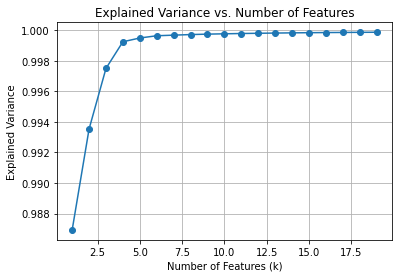

In [54]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming your data is stored in a variable called 'X'

# Define the range of k values
k_values = range(1, 20)

# List to store explained variances
explained_variances = []

# Apply PCA for each k and store explained variance
for k in k_values:
    pca = PCA(n_components=k)
    pca.fit(X_train)
    explained_variances.append(sum(pca.explained_variance_ratio_))

# Plot explained variance vs. number of features
plt.plot(k_values, explained_variances, marker='o')
plt.xlabel('Number of Features (k)')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Features')
plt.grid(True)
plt.show()


In [57]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

def train_regression_model(model, X_train, Y_train, X_test, y_test, pca_components=None, epochs=50, batch_size=2):
    # If PCA components are specified, create a PCA instance
    if pca_components:
        pca = PCA(n_components=pca_components)

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Train the model
    model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    # Evaluate the model
    loss, mae = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    print("Test MAE:", mae)


# Define a list of model names
model_names = ["LucasCNN", "HuEtAl", "LiuEtAl", "LucasCoordConv"]

# Define the range of PCA components to try
pca_components_list = [2, 4, 6, 8]

# Iterate over each model name
for model_name in model_names:
    # Get the model
    model = getKerasModel(model_name)
    
    # If the model exists, train it with different PCA components
    if model:
        print("Training", model_name)
        for pca_components in pca_components_list:
            print("Using PCA components:", pca_components)
            train_regression_model(model, X_train, y_train, X_test, y_test, pca_components=pca_components)
            print("\n")
    else:
        print("Error: Model", model_name, "not implemented.")


Training LucasCNN
Using PCA components: 2
Epoch 1/50
217/217 [==============================] - 2s 5ms/step - loss: 194.9167 - mae: 9.4138 - val_loss: 20.8274 - val_mae: 3.9817
Epoch 2/50
217/217 [==============================] - 1s 4ms/step - loss: 18.9356 - mae: 3.6368 - val_loss: 17.6934 - val_mae: 3.5843
Epoch 3/50
217/217 [==============================] - 1s 4ms/step - loss: 19.2570 - mae: 3.6972 - val_loss: 16.9849 - val_mae: 3.3834
Epoch 4/50
217/217 [==============================] - 1s 4ms/step - loss: 19.4260 - mae: 3.6945 - val_loss: 20.2658 - val_mae: 3.6986
Epoch 5/50
217/217 [==============================] - 1s 4ms/step - loss: 19.3549 - mae: 3.6733 - val_loss: 17.8534 - val_mae: 3.6208
Epoch 6/50
217/217 [==============================] - 1s 4ms/step - loss: 19.2609 - mae: 3.6390 - val_loss: 26.6064 - val_mae: 4.1641
Epoch 7/50
217/217 [==============================] - 1s 4ms/step - loss: 19.5711 - mae: 3.7269 - val_loss: 17.2674 - val_mae: 3.4726
Epoch 8/50
217/217 

Epoch 11/50
217/217 [==============================] - 1s 4ms/step - loss: 4.5747 - mae: 1.6617 - val_loss: 6.6888 - val_mae: 1.9935
Epoch 12/50
217/217 [==============================] - 1s 4ms/step - loss: 4.3412 - mae: 1.6135 - val_loss: 5.5707 - val_mae: 1.9402
Epoch 13/50
217/217 [==============================] - 1s 4ms/step - loss: 4.4272 - mae: 1.6296 - val_loss: 4.9887 - val_mae: 1.6791
Epoch 14/50
217/217 [==============================] - 1s 4ms/step - loss: 4.5367 - mae: 1.6545 - val_loss: 6.2467 - val_mae: 2.0821
Epoch 15/50
217/217 [==============================] - 1s 4ms/step - loss: 4.1176 - mae: 1.5574 - val_loss: 5.2231 - val_mae: 1.7604
Epoch 16/50
217/217 [==============================] - 1s 4ms/step - loss: 4.7821 - mae: 1.7157 - val_loss: 4.0583 - val_mae: 1.6219
Epoch 17/50
217/217 [==============================] - 1s 4ms/step - loss: 4.6438 - mae: 1.6719 - val_loss: 4.3773 - val_mae: 1.7145
Epoch 18/50
217/217 [==============================] - 1s 4ms/step - 

217/217 [==============================] - 1s 4ms/step - loss: 0.8941 - mae: 0.6938 - val_loss: 0.8837 - val_mae: 0.6522
Epoch 32/50
217/217 [==============================] - 1s 4ms/step - loss: 1.0454 - mae: 0.7393 - val_loss: 0.9567 - val_mae: 0.7149
Epoch 33/50
217/217 [==============================] - 1s 4ms/step - loss: 0.9528 - mae: 0.7119 - val_loss: 0.9116 - val_mae: 0.7212
Epoch 34/50
217/217 [==============================] - 1s 4ms/step - loss: 0.9130 - mae: 0.6898 - val_loss: 0.7143 - val_mae: 0.5981
Epoch 35/50
217/217 [==============================] - 1s 4ms/step - loss: 0.8997 - mae: 0.6913 - val_loss: 0.9141 - val_mae: 0.7413
Epoch 36/50
217/217 [==============================] - 1s 4ms/step - loss: 0.9704 - mae: 0.7293 - val_loss: 1.0989 - val_mae: 0.8350
Epoch 37/50
217/217 [==============================] - 1s 4ms/step - loss: 0.9085 - mae: 0.6977 - val_loss: 0.9389 - val_mae: 0.7650
Epoch 38/50
217/217 [==============================] - 1s 4ms/step - loss: 0.8206

217/217 [==============================] - 0s 2ms/step - loss: 3.7240 - mae: 1.4758 - val_loss: 3.4505 - val_mae: 1.3951
Epoch 42/50
217/217 [==============================] - 0s 2ms/step - loss: 3.5280 - mae: 1.4315 - val_loss: 3.2391 - val_mae: 1.3574
Epoch 43/50
217/217 [==============================] - 0s 2ms/step - loss: 3.3056 - mae: 1.3780 - val_loss: 3.0136 - val_mae: 1.3081
Epoch 44/50
217/217 [==============================] - 0s 2ms/step - loss: 3.0778 - mae: 1.3303 - val_loss: 2.8012 - val_mae: 1.2142
Epoch 45/50
217/217 [==============================] - 0s 2ms/step - loss: 3.1420 - mae: 1.3332 - val_loss: 2.7301 - val_mae: 1.1847
Epoch 46/50
217/217 [==============================] - 0s 2ms/step - loss: 3.0569 - mae: 1.2849 - val_loss: 2.8387 - val_mae: 1.2207
Epoch 47/50
217/217 [==============================] - 0s 2ms/step - loss: 3.1804 - mae: 1.3284 - val_loss: 2.6555 - val_mae: 1.1594
Epoch 48/50
217/217 [==============================] - 0s 2ms/step - loss: 2.8775

217/217 [==============================] - 0s 2ms/step - loss: 0.8265 - mae: 0.6499 - val_loss: 0.6605 - val_mae: 0.5924
Epoch 11/50
217/217 [==============================] - 0s 2ms/step - loss: 0.7113 - mae: 0.5985 - val_loss: 0.9256 - val_mae: 0.7172
Epoch 12/50
217/217 [==============================] - 0s 2ms/step - loss: 0.7535 - mae: 0.6147 - val_loss: 0.7668 - val_mae: 0.6250
Epoch 13/50
217/217 [==============================] - 0s 2ms/step - loss: 0.7558 - mae: 0.6141 - val_loss: 0.7208 - val_mae: 0.6189
Epoch 14/50
217/217 [==============================] - 0s 2ms/step - loss: 0.6743 - mae: 0.5925 - val_loss: 0.7598 - val_mae: 0.6447
Epoch 15/50
217/217 [==============================] - 0s 2ms/step - loss: 0.8126 - mae: 0.6374 - val_loss: 0.7762 - val_mae: 0.6516
Epoch 16/50
217/217 [==============================] - 0s 2ms/step - loss: 0.7152 - mae: 0.6002 - val_loss: 0.9034 - val_mae: 0.6872
Epoch 17/50
217/217 [==============================] - 0s 2ms/step - loss: 0.6688

217/217 [==============================] - 1s 4ms/step - loss: 4.8032 - mae: 1.6844 - val_loss: 4.2614 - val_mae: 1.5776
Epoch 31/50
217/217 [==============================] - 1s 4ms/step - loss: 4.7662 - mae: 1.6990 - val_loss: 4.0862 - val_mae: 1.5523
Epoch 32/50
217/217 [==============================] - 1s 4ms/step - loss: 4.2767 - mae: 1.5769 - val_loss: 4.9448 - val_mae: 1.7520
Epoch 33/50
217/217 [==============================] - 1s 4ms/step - loss: 4.7729 - mae: 1.6922 - val_loss: 5.0044 - val_mae: 1.7739
Epoch 34/50
217/217 [==============================] - 1s 4ms/step - loss: 4.4791 - mae: 1.6355 - val_loss: 4.4089 - val_mae: 1.6373
Epoch 35/50
217/217 [==============================] - 1s 4ms/step - loss: 4.4700 - mae: 1.6365 - val_loss: 5.0968 - val_mae: 1.7796
Epoch 36/50
217/217 [==============================] - 1s 4ms/step - loss: 4.3109 - mae: 1.5772 - val_loss: 4.7665 - val_mae: 1.7423
Epoch 37/50
217/217 [==============================] - 1s 4ms/step - loss: 4.6650

5/5 [==============================] - 0s 3ms/step - loss: 3.0412 - mae: 1.2750
Test Loss: 3.041205644607544
Test MAE: 1.2749828100204468


Training LucasCoordConv
Using PCA components: 2
Epoch 1/50
217/217 [==============================] - 2s 5ms/step - loss: 196.1827 - mae: 9.6797 - val_loss: 18.6717 - val_mae: 3.6004
Epoch 2/50
217/217 [==============================] - 1s 4ms/step - loss: 19.1725 - mae: 3.6758 - val_loss: 16.9708 - val_mae: 3.5121
Epoch 3/50
217/217 [==============================] - 1s 4ms/step - loss: 19.2356 - mae: 3.6822 - val_loss: 18.2145 - val_mae: 3.5647
Epoch 4/50
217/217 [==============================] - 1s 4ms/step - loss: 18.3257 - mae: 3.5778 - val_loss: 13.4358 - val_mae: 3.0428
Epoch 5/50
217/217 [==============================] - 1s 4ms/step - loss: 13.8335 - mae: 2.9876 - val_loss: 9.4519 - val_mae: 2.4677
Epoch 6/50
217/217 [==============================] - 1s 4ms/step - loss: 10.9477 - mae: 2.5851 - val_loss: 8.5234 - val_mae: 2.4540
Epoch 7/5

217/217 [==============================] - 1s 4ms/step - loss: 3.3525 - mae: 1.4227 - val_loss: 3.0889 - val_mae: 1.3566
Epoch 10/50
217/217 [==============================] - 1s 4ms/step - loss: 3.2201 - mae: 1.3996 - val_loss: 2.2892 - val_mae: 1.0835
Epoch 11/50
217/217 [==============================] - 1s 4ms/step - loss: 3.0633 - mae: 1.3717 - val_loss: 2.5817 - val_mae: 1.1645
Epoch 12/50
217/217 [==============================] - 1s 4ms/step - loss: 2.8103 - mae: 1.2998 - val_loss: 1.9982 - val_mae: 1.1003
Epoch 13/50
217/217 [==============================] - 1s 4ms/step - loss: 2.3977 - mae: 1.1796 - val_loss: 1.8700 - val_mae: 1.0523
Epoch 14/50
217/217 [==============================] - 1s 4ms/step - loss: 2.2054 - mae: 1.1329 - val_loss: 2.0515 - val_mae: 1.1170
Epoch 15/50
217/217 [==============================] - 1s 4ms/step - loss: 2.2864 - mae: 1.1520 - val_loss: 2.9406 - val_mae: 1.4199
Epoch 16/50
217/217 [==============================] - 1s 4ms/step - loss: 2.3206

217/217 [==============================] - 1s 4ms/step - loss: 0.9167 - mae: 0.6952 - val_loss: 0.7359 - val_mae: 0.6063
Epoch 30/50
217/217 [==============================] - 1s 4ms/step - loss: 0.7657 - mae: 0.6447 - val_loss: 0.7356 - val_mae: 0.6330
Epoch 31/50
217/217 [==============================] - 1s 4ms/step - loss: 0.7653 - mae: 0.6469 - val_loss: 0.7079 - val_mae: 0.5974
Epoch 32/50
217/217 [==============================] - 1s 4ms/step - loss: 0.9313 - mae: 0.7424 - val_loss: 0.8843 - val_mae: 0.7351
Epoch 33/50
217/217 [==============================] - 1s 4ms/step - loss: 0.7968 - mae: 0.6541 - val_loss: 0.9436 - val_mae: 0.7309
Epoch 34/50
217/217 [==============================] - 1s 4ms/step - loss: 0.9103 - mae: 0.7207 - val_loss: 1.1520 - val_mae: 0.8766
Epoch 35/50
217/217 [==============================] - 1s 4ms/step - loss: 0.8044 - mae: 0.6603 - val_loss: 0.6764 - val_mae: 0.5775
Epoch 36/50
217/217 [==============================] - 1s 4ms/step - loss: 0.8272

In [62]:
from sklearn.metrics import mean_squared_error

# Assuming X_train, Y_train, X_test, y_test are defined

def train_regression_model(model, X_train, Y_train, X_test, y_test, epochs=2000, batch_size=1):
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Train the model
    model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    # Evaluate the model
    loss, mae = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    print("Test MAE:", mae)


# Define a list of model names
model_names = ["LucasCNN", "HuEtAl", "LiuEtAl", "LucasCoordConv"]


# Iterate over each model name
for model_name in model_names:
    # Get the model
    model = getKerasModel(model_name)
    
    # If the model exists, train it
    if model:
        print("Training", model_name)
        train_regression_model(model, X_train, y_train, X_test, y_test)
        print("\n")
    else:
        print("Error: Model", model_name, "not implemented.")


In [63]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(125, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2)  # No activation function for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])  # Using mean squared error loss for regression

# Print model summary
model.summary()

# Train the model
train_regression_model(model, X_train, y_train, X_test, y_test)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_31 (Conv1D)          (None, 123, 64)           256       
                                                                 
 max_pooling1d_31 (MaxPoolin  (None, 61, 64)           0         
 g1D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 3904)              0         
                                                                 
 dense_36 (Dense)            (None, 128)               499840    
                                                                 
 dense_37 (Dense)            (None, 64)                8256      
                                                                 
 dense_38 (Dense)            (None, 2)                 130       
                                                      

Epoch 113/2000
434/434 [==============================] - 1s 3ms/step - loss: 1.6560 - mae: 0.9534 - val_loss: 1.1439 - val_mae: 0.8122
Epoch 114/2000
434/434 [==============================] - 1s 3ms/step - loss: 1.7413 - mae: 0.9866 - val_loss: 1.9676 - val_mae: 1.1583
Epoch 115/2000
434/434 [==============================] - 1s 3ms/step - loss: 1.7584 - mae: 0.9851 - val_loss: 1.1945 - val_mae: 0.8423
Epoch 116/2000
434/434 [==============================] - 1s 3ms/step - loss: 1.6367 - mae: 0.9278 - val_loss: 1.5598 - val_mae: 0.9854
Epoch 117/2000
434/434 [==============================] - 1s 3ms/step - loss: 2.0698 - mae: 1.0464 - val_loss: 3.4982 - val_mae: 1.4936
Epoch 118/2000
434/434 [==============================] - 1s 3ms/step - loss: 1.8501 - mae: 1.0070 - val_loss: 1.9751 - val_mae: 1.0391
Epoch 119/2000
434/434 [==============================] - 1s 3ms/step - loss: 1.6539 - mae: 0.9430 - val_loss: 1.3242 - val_mae: 0.8691
Epoch 120/2000
434/434 [========================

434/434 [==============================] - 1s 3ms/step - loss: 0.8537 - mae: 0.6813 - val_loss: 2.0468 - val_mae: 1.1912
Epoch 234/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.8825 - mae: 0.6991 - val_loss: 0.8670 - val_mae: 0.6895
Epoch 235/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.7834 - mae: 0.6493 - val_loss: 1.8233 - val_mae: 1.0883
Epoch 236/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.9295 - mae: 0.7101 - val_loss: 0.8637 - val_mae: 0.7019
Epoch 237/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.9107 - mae: 0.7132 - val_loss: 1.3405 - val_mae: 0.9384
Epoch 238/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.8495 - mae: 0.6808 - val_loss: 0.8923 - val_mae: 0.7007
Epoch 239/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.8675 - mae: 0.6751 - val_loss: 1.0758 - val_mae: 0.7556
Epoch 240/2000
434/434 [==============================] - 1s 3m

434/434 [==============================] - 1s 3ms/step - loss: 0.6278 - mae: 0.5782 - val_loss: 1.0105 - val_mae: 0.7046
Epoch 354/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.5410 - mae: 0.5414 - val_loss: 0.8427 - val_mae: 0.6818
Epoch 355/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.5336 - mae: 0.5468 - val_loss: 1.2599 - val_mae: 0.8489
Epoch 356/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.6022 - mae: 0.5805 - val_loss: 1.2319 - val_mae: 0.8272
Epoch 357/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.5405 - mae: 0.5402 - val_loss: 0.7569 - val_mae: 0.6169
Epoch 358/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.5085 - mae: 0.5372 - val_loss: 1.0384 - val_mae: 0.7157
Epoch 359/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.5548 - mae: 0.5427 - val_loss: 0.7974 - val_mae: 0.6393
Epoch 360/2000
434/434 [==============================] - 1s 3m

434/434 [==============================] - 1s 3ms/step - loss: 0.3671 - mae: 0.4501 - val_loss: 0.8707 - val_mae: 0.6259
Epoch 474/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.5052 - mae: 0.5361 - val_loss: 0.7443 - val_mae: 0.5896
Epoch 475/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.4028 - mae: 0.4678 - val_loss: 0.9323 - val_mae: 0.6386
Epoch 476/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.3321 - mae: 0.4394 - val_loss: 0.7864 - val_mae: 0.6419
Epoch 477/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.3813 - mae: 0.4644 - val_loss: 0.8439 - val_mae: 0.6685
Epoch 478/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.4064 - mae: 0.4705 - val_loss: 0.7477 - val_mae: 0.6209
Epoch 479/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.4301 - mae: 0.4928 - val_loss: 0.8619 - val_mae: 0.6398
Epoch 480/2000
434/434 [==============================] - 1s 3m

434/434 [==============================] - 1s 3ms/step - loss: 0.3921 - mae: 0.4686 - val_loss: 0.7459 - val_mae: 0.5641
Epoch 594/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.2804 - mae: 0.3839 - val_loss: 0.7804 - val_mae: 0.6029
Epoch 595/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.2987 - mae: 0.4129 - val_loss: 0.8065 - val_mae: 0.6261
Epoch 596/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.3657 - mae: 0.4553 - val_loss: 0.9387 - val_mae: 0.6852
Epoch 597/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.3179 - mae: 0.4303 - val_loss: 0.8154 - val_mae: 0.5918
Epoch 598/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.3337 - mae: 0.4311 - val_loss: 0.7353 - val_mae: 0.5635
Epoch 599/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.3513 - mae: 0.4481 - val_loss: 0.7522 - val_mae: 0.5791
Epoch 600/2000
434/434 [==============================] - 1s 3m

434/434 [==============================] - 1s 3ms/step - loss: 0.2362 - mae: 0.3714 - val_loss: 1.0090 - val_mae: 0.7555
Epoch 714/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.3056 - mae: 0.4202 - val_loss: 0.8393 - val_mae: 0.6673
Epoch 715/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.2537 - mae: 0.3802 - val_loss: 0.7876 - val_mae: 0.6074
Epoch 716/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.2107 - mae: 0.3487 - val_loss: 0.7361 - val_mae: 0.5537
Epoch 717/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.2400 - mae: 0.3785 - val_loss: 0.8065 - val_mae: 0.6006
Epoch 718/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.2572 - mae: 0.3840 - val_loss: 0.7221 - val_mae: 0.6179
Epoch 719/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.2387 - mae: 0.3708 - val_loss: 0.7153 - val_mae: 0.5760
Epoch 720/2000
434/434 [==============================] - 1s 3m

434/434 [==============================] - 1s 3ms/step - loss: 0.2055 - mae: 0.3524 - val_loss: 0.7384 - val_mae: 0.5741
Epoch 834/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1897 - mae: 0.3343 - val_loss: 0.8193 - val_mae: 0.6451
Epoch 835/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.2108 - mae: 0.3459 - val_loss: 0.8323 - val_mae: 0.6618
Epoch 836/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1959 - mae: 0.3414 - val_loss: 0.7354 - val_mae: 0.5637
Epoch 837/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.2296 - mae: 0.3625 - val_loss: 0.7206 - val_mae: 0.6142
Epoch 838/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1819 - mae: 0.3273 - val_loss: 1.0699 - val_mae: 0.7509
Epoch 839/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1959 - mae: 0.3377 - val_loss: 0.7564 - val_mae: 0.5919
Epoch 840/2000
434/434 [==============================] - 1s 3m

434/434 [==============================] - 1s 3ms/step - loss: 0.1469 - mae: 0.2963 - val_loss: 0.7373 - val_mae: 0.6022
Epoch 954/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1375 - mae: 0.2883 - val_loss: 0.7510 - val_mae: 0.5979
Epoch 955/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1641 - mae: 0.3097 - val_loss: 1.0008 - val_mae: 0.7138
Epoch 956/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1799 - mae: 0.3211 - val_loss: 0.7865 - val_mae: 0.5968
Epoch 957/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1544 - mae: 0.3059 - val_loss: 0.7686 - val_mae: 0.6084
Epoch 958/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1467 - mae: 0.2971 - val_loss: 0.7959 - val_mae: 0.5835
Epoch 959/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1781 - mae: 0.3123 - val_loss: 0.7064 - val_mae: 0.5914
Epoch 960/2000
434/434 [==============================] - 1s 3m

Epoch 1073/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1291 - mae: 0.2769 - val_loss: 0.8840 - val_mae: 0.6437
Epoch 1074/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1316 - mae: 0.2801 - val_loss: 0.7336 - val_mae: 0.5812
Epoch 1075/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1681 - mae: 0.3120 - val_loss: 0.8544 - val_mae: 0.6301
Epoch 1076/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1432 - mae: 0.2888 - val_loss: 0.8464 - val_mae: 0.6347
Epoch 1077/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1462 - mae: 0.2946 - val_loss: 0.8656 - val_mae: 0.6216
Epoch 1078/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1372 - mae: 0.2852 - val_loss: 0.8645 - val_mae: 0.6210
Epoch 1079/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1598 - mae: 0.3089 - val_loss: 0.8387 - val_mae: 0.5982
Epoch 1080/2000
434/434 [================

Epoch 1133/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1215 - mae: 0.2660 - val_loss: 0.9632 - val_mae: 0.6918
Epoch 1134/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1712 - mae: 0.3039 - val_loss: 0.7974 - val_mae: 0.6044
Epoch 1135/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1297 - mae: 0.2677 - val_loss: 0.7423 - val_mae: 0.5591
Epoch 1136/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1396 - mae: 0.2862 - val_loss: 0.7999 - val_mae: 0.6157
Epoch 1137/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1140 - mae: 0.2635 - val_loss: 0.8123 - val_mae: 0.5889
Epoch 1138/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1427 - mae: 0.2914 - val_loss: 0.7304 - val_mae: 0.5751
Epoch 1139/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1362 - mae: 0.2841 - val_loss: 0.8058 - val_mae: 0.5777
Epoch 1140/2000
434/434 [================

Epoch 1193/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1223 - mae: 0.2729 - val_loss: 0.8431 - val_mae: 0.5837
Epoch 1194/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1101 - mae: 0.2556 - val_loss: 0.8073 - val_mae: 0.6066
Epoch 1195/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1104 - mae: 0.2640 - val_loss: 0.9319 - val_mae: 0.6654
Epoch 1196/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1145 - mae: 0.2574 - val_loss: 0.9160 - val_mae: 0.7184
Epoch 1197/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1681 - mae: 0.3149 - val_loss: 0.9183 - val_mae: 0.6610
Epoch 1198/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1280 - mae: 0.2790 - val_loss: 0.9013 - val_mae: 0.6346
Epoch 1199/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0930 - mae: 0.2365 - val_loss: 1.1773 - val_mae: 0.7253
Epoch 1200/2000
434/434 [================

Epoch 1253/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1330 - mae: 0.2682 - val_loss: 0.8870 - val_mae: 0.6137
Epoch 1254/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0789 - mae: 0.2177 - val_loss: 1.0876 - val_mae: 0.7232
Epoch 1255/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0991 - mae: 0.2411 - val_loss: 0.8183 - val_mae: 0.5906
Epoch 1256/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1779 - mae: 0.3214 - val_loss: 0.8524 - val_mae: 0.6296
Epoch 1257/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1124 - mae: 0.2570 - val_loss: 0.8151 - val_mae: 0.6112
Epoch 1258/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1265 - mae: 0.2703 - val_loss: 0.8194 - val_mae: 0.6034
Epoch 1259/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0805 - mae: 0.2225 - val_loss: 0.7780 - val_mae: 0.5803
Epoch 1260/2000
434/434 [================

Epoch 1313/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0763 - mae: 0.2105 - val_loss: 0.8244 - val_mae: 0.5960
Epoch 1314/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0982 - mae: 0.2401 - val_loss: 0.8301 - val_mae: 0.5942
Epoch 1315/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1107 - mae: 0.2525 - val_loss: 0.8037 - val_mae: 0.6113
Epoch 1316/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0915 - mae: 0.2372 - val_loss: 0.8466 - val_mae: 0.6003
Epoch 1317/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1597 - mae: 0.2931 - val_loss: 0.8406 - val_mae: 0.6047
Epoch 1318/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1032 - mae: 0.2437 - val_loss: 0.8469 - val_mae: 0.6103
Epoch 1319/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0696 - mae: 0.2026 - val_loss: 0.8508 - val_mae: 0.6422
Epoch 1320/2000
434/434 [================

Epoch 1373/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1801 - mae: 0.3107 - val_loss: 0.8090 - val_mae: 0.6189
Epoch 1374/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0706 - mae: 0.2018 - val_loss: 0.8774 - val_mae: 0.5905
Epoch 1375/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0924 - mae: 0.2263 - val_loss: 0.8840 - val_mae: 0.6169
Epoch 1376/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1000 - mae: 0.2375 - val_loss: 0.8824 - val_mae: 0.6174
Epoch 1377/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0893 - mae: 0.2246 - val_loss: 0.9958 - val_mae: 0.6989
Epoch 1378/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0785 - mae: 0.2133 - val_loss: 0.8611 - val_mae: 0.5945
Epoch 1379/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1061 - mae: 0.2561 - val_loss: 1.1141 - val_mae: 0.7347
Epoch 1380/2000
434/434 [================

Epoch 1433/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0778 - mae: 0.2136 - val_loss: 0.7685 - val_mae: 0.5698
Epoch 1434/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0813 - mae: 0.2189 - val_loss: 0.8503 - val_mae: 0.5861
Epoch 1435/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1759 - mae: 0.3133 - val_loss: 0.7857 - val_mae: 0.5513
Epoch 1436/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0722 - mae: 0.2065 - val_loss: 0.8809 - val_mae: 0.5976
Epoch 1437/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0899 - mae: 0.2244 - val_loss: 0.8169 - val_mae: 0.5831
Epoch 1438/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0634 - mae: 0.1898 - val_loss: 0.8217 - val_mae: 0.5868
Epoch 1439/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0895 - mae: 0.2282 - val_loss: 0.8435 - val_mae: 0.5950
Epoch 1440/2000
434/434 [================

Epoch 1493/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0725 - mae: 0.2063 - val_loss: 0.7798 - val_mae: 0.5528
Epoch 1494/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0813 - mae: 0.2210 - val_loss: 0.9404 - val_mae: 0.6305
Epoch 1495/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1140 - mae: 0.2582 - val_loss: 0.8453 - val_mae: 0.6012
Epoch 1496/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0976 - mae: 0.2362 - val_loss: 0.7891 - val_mae: 0.5728
Epoch 1497/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0936 - mae: 0.2334 - val_loss: 0.8445 - val_mae: 0.6211
Epoch 1498/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0700 - mae: 0.2039 - val_loss: 0.9036 - val_mae: 0.6184
Epoch 1499/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0997 - mae: 0.2405 - val_loss: 0.9692 - val_mae: 0.6644
Epoch 1500/2000
434/434 [================

Epoch 1553/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0834 - mae: 0.2255 - val_loss: 0.9782 - val_mae: 0.6681
Epoch 1554/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0908 - mae: 0.2286 - val_loss: 0.7732 - val_mae: 0.5650
Epoch 1555/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0885 - mae: 0.2297 - val_loss: 0.8190 - val_mae: 0.5784
Epoch 1556/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0831 - mae: 0.2216 - val_loss: 0.9679 - val_mae: 0.6631
Epoch 1557/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1731 - mae: 0.2930 - val_loss: 0.9333 - val_mae: 0.6505
Epoch 1558/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0764 - mae: 0.2033 - val_loss: 0.8886 - val_mae: 0.5962
Epoch 1559/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0550 - mae: 0.1846 - val_loss: 1.0827 - val_mae: 0.7149
Epoch 1560/2000
434/434 [================

Epoch 1613/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0554 - mae: 0.1819 - val_loss: 0.8294 - val_mae: 0.6187
Epoch 1614/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0800 - mae: 0.2164 - val_loss: 0.8369 - val_mae: 0.5978
Epoch 1615/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0777 - mae: 0.2168 - val_loss: 0.9313 - val_mae: 0.6177
Epoch 1616/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1105 - mae: 0.2505 - val_loss: 0.9317 - val_mae: 0.6384
Epoch 1617/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0662 - mae: 0.1983 - val_loss: 0.8182 - val_mae: 0.5854
Epoch 1618/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1007 - mae: 0.2355 - val_loss: 0.8462 - val_mae: 0.6167
Epoch 1619/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0857 - mae: 0.2248 - val_loss: 0.9120 - val_mae: 0.6202
Epoch 1620/2000
434/434 [================

Epoch 1673/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0809 - mae: 0.2131 - val_loss: 0.8425 - val_mae: 0.6005
Epoch 1674/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0543 - mae: 0.1823 - val_loss: 0.8466 - val_mae: 0.5880
Epoch 1675/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0641 - mae: 0.1946 - val_loss: 0.7994 - val_mae: 0.5790
Epoch 1676/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0768 - mae: 0.2093 - val_loss: 0.9143 - val_mae: 0.6299
Epoch 1677/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0782 - mae: 0.2179 - val_loss: 0.8150 - val_mae: 0.6006
Epoch 1678/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0743 - mae: 0.2067 - val_loss: 0.8896 - val_mae: 0.6173
Epoch 1679/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1285 - mae: 0.2617 - val_loss: 0.8783 - val_mae: 0.6111
Epoch 1680/2000
434/434 [================

Epoch 1733/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0849 - mae: 0.2253 - val_loss: 0.8053 - val_mae: 0.6051
Epoch 1734/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0947 - mae: 0.2353 - val_loss: 0.9529 - val_mae: 0.6677
Epoch 1735/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0746 - mae: 0.2123 - val_loss: 0.9014 - val_mae: 0.5942
Epoch 1736/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1206 - mae: 0.2595 - val_loss: 0.9580 - val_mae: 0.6605
Epoch 1737/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0980 - mae: 0.2368 - val_loss: 0.9206 - val_mae: 0.6248
Epoch 1738/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0583 - mae: 0.1895 - val_loss: 1.1194 - val_mae: 0.7399
Epoch 1739/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0708 - mae: 0.2052 - val_loss: 0.7987 - val_mae: 0.5684
Epoch 1740/2000
434/434 [================

Epoch 1793/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0985 - mae: 0.2368 - val_loss: 0.8772 - val_mae: 0.5931
Epoch 1794/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0543 - mae: 0.1823 - val_loss: 0.8983 - val_mae: 0.6041
Epoch 1795/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1195 - mae: 0.2452 - val_loss: 0.8701 - val_mae: 0.5993
Epoch 1796/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0597 - mae: 0.1946 - val_loss: 0.8948 - val_mae: 0.6127
Epoch 1797/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0698 - mae: 0.1979 - val_loss: 0.8446 - val_mae: 0.5729
Epoch 1798/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0482 - mae: 0.1701 - val_loss: 0.8966 - val_mae: 0.6282
Epoch 1799/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0687 - mae: 0.2022 - val_loss: 0.8163 - val_mae: 0.5797
Epoch 1800/2000
434/434 [================

Epoch 1853/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0475 - mae: 0.1692 - val_loss: 0.8085 - val_mae: 0.5728
Epoch 1854/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0401 - mae: 0.1573 - val_loss: 0.8211 - val_mae: 0.5646
Epoch 1855/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0671 - mae: 0.1986 - val_loss: 0.8931 - val_mae: 0.5959
Epoch 1856/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1108 - mae: 0.2454 - val_loss: 0.8622 - val_mae: 0.5912
Epoch 1857/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0547 - mae: 0.1796 - val_loss: 0.8869 - val_mae: 0.6079
Epoch 1858/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.1104 - mae: 0.2466 - val_loss: 0.8062 - val_mae: 0.5747
Epoch 1859/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0604 - mae: 0.1789 - val_loss: 0.8276 - val_mae: 0.5817
Epoch 1860/2000
434/434 [================

Epoch 1913/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0642 - mae: 0.1954 - val_loss: 0.7978 - val_mae: 0.5759
Epoch 1914/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0681 - mae: 0.1970 - val_loss: 0.8040 - val_mae: 0.5809
Epoch 1915/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0658 - mae: 0.1956 - val_loss: 0.8756 - val_mae: 0.5953
Epoch 1916/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0882 - mae: 0.2255 - val_loss: 0.9306 - val_mae: 0.6117
Epoch 1917/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0440 - mae: 0.1610 - val_loss: 0.8619 - val_mae: 0.5830
Epoch 1918/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0448 - mae: 0.1606 - val_loss: 0.8228 - val_mae: 0.5861
Epoch 1919/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0581 - mae: 0.1788 - val_loss: 0.9453 - val_mae: 0.6548
Epoch 1920/2000
434/434 [================

Epoch 1973/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0840 - mae: 0.2151 - val_loss: 0.8136 - val_mae: 0.5715
Epoch 1974/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0556 - mae: 0.1814 - val_loss: 0.8800 - val_mae: 0.5958
Epoch 1975/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0484 - mae: 0.1672 - val_loss: 0.8670 - val_mae: 0.5913
Epoch 1976/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0554 - mae: 0.1824 - val_loss: 0.9059 - val_mae: 0.6051
Epoch 1977/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0907 - mae: 0.2261 - val_loss: 0.8871 - val_mae: 0.6226
Epoch 1978/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0811 - mae: 0.2112 - val_loss: 0.8210 - val_mae: 0.5888
Epoch 1979/2000
434/434 [==============================] - 1s 3ms/step - loss: 0.0465 - mae: 0.1685 - val_loss: 0.9318 - val_mae: 0.6768
Epoch 1980/2000
434/434 [================

In [14]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 4ms/step - loss: 3.2891 - mae: 1.4002


[3.2891271114349365, 1.400221824645996]

In [13]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 6ms/step - loss: 8.1358 - mae: 2.1782


[8.135807037353516, 2.1781575679779053]

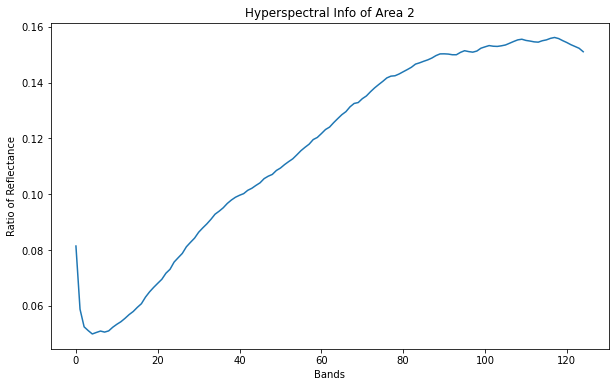

In [39]:
import matplotlib.pyplot as plt

# Example vector of length 125

# Plot the vector
plt.figure(figsize=(10, 6))
plt.plot(X_train[2,:])
plt.xlabel('Bands')
plt.ylabel('Ratio of Reflectance')
plt.title('Hyperspectral Info of Area 2')
plt.show()


In [43]:
y_train

array([33.9 , 36.04])

In [46]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(125, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2)  # No activation function for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae']) 

train_regression_model(model, X_train, y_train, X_test, y_test)

Epoch 1/200
109/109 [==============================] - 1s 4ms/step - loss: 265.9442 - mae: 11.6013 - val_loss: 26.8215 - val_mae: 4.1381
Epoch 2/200
109/109 [==============================] - 0s 3ms/step - loss: 28.0886 - mae: 4.3057 - val_loss: 26.4413 - val_mae: 3.9972
Epoch 3/200
109/109 [==============================] - 0s 3ms/step - loss: 25.2066 - mae: 4.0739 - val_loss: 21.4809 - val_mae: 3.7895
Epoch 4/200
109/109 [==============================] - 0s 3ms/step - loss: 21.5875 - mae: 3.8029 - val_loss: 20.4966 - val_mae: 3.7187
Epoch 5/200
109/109 [==============================] - 0s 3ms/step - loss: 20.1692 - mae: 3.6956 - val_loss: 17.1504 - val_mae: 3.4635
Epoch 6/200
109/109 [==============================] - 0s 3ms/step - loss: 17.8812 - mae: 3.5369 - val_loss: 15.5021 - val_mae: 3.3477
Epoch 7/200
109/109 [==============================] - 0s 3ms/step - loss: 16.9909 - mae: 3.4153 - val_loss: 15.6216 - val_mae: 3.3061
Epoch 8/200
109/109 [==============================] 

109/109 [==============================] - 0s 3ms/step - loss: 6.1844 - mae: 1.9329 - val_loss: 6.0069 - val_mae: 1.9483
Epoch 63/200
109/109 [==============================] - 0s 3ms/step - loss: 5.9330 - mae: 1.8685 - val_loss: 4.5231 - val_mae: 1.6373
Epoch 64/200
109/109 [==============================] - 0s 3ms/step - loss: 5.7262 - mae: 1.8403 - val_loss: 5.4602 - val_mae: 1.9198
Epoch 65/200
109/109 [==============================] - 0s 3ms/step - loss: 6.0679 - mae: 1.8860 - val_loss: 4.5714 - val_mae: 1.6759
Epoch 66/200
109/109 [==============================] - 0s 3ms/step - loss: 6.0808 - mae: 1.9213 - val_loss: 4.5147 - val_mae: 1.5613
Epoch 67/200
109/109 [==============================] - 0s 3ms/step - loss: 5.7114 - mae: 1.8430 - val_loss: 4.7340 - val_mae: 1.6623
Epoch 68/200
109/109 [==============================] - 0s 3ms/step - loss: 5.4597 - mae: 1.7928 - val_loss: 4.8142 - val_mae: 1.7582
Epoch 69/200
109/109 [==============================] - 0s 3ms/step - loss:

109/109 [==============================] - 0s 3ms/step - loss: 4.1722 - mae: 1.5708 - val_loss: 2.9057 - val_mae: 1.2779
Epoch 124/200
109/109 [==============================] - 0s 3ms/step - loss: 3.9894 - mae: 1.5311 - val_loss: 3.9930 - val_mae: 1.5471
Epoch 125/200
109/109 [==============================] - 0s 3ms/step - loss: 4.0143 - mae: 1.5223 - val_loss: 3.4362 - val_mae: 1.4788
Epoch 126/200
109/109 [==============================] - 0s 3ms/step - loss: 4.2939 - mae: 1.6029 - val_loss: 2.9167 - val_mae: 1.3375
Epoch 127/200
109/109 [==============================] - 0s 3ms/step - loss: 3.9325 - mae: 1.4864 - val_loss: 2.9672 - val_mae: 1.3041
Epoch 128/200
109/109 [==============================] - 0s 3ms/step - loss: 3.8537 - mae: 1.4857 - val_loss: 4.1048 - val_mae: 1.7014
Epoch 129/200
109/109 [==============================] - 0s 3ms/step - loss: 4.1681 - mae: 1.5746 - val_loss: 4.0441 - val_mae: 1.6420
Epoch 130/200
109/109 [==============================] - 0s 3ms/step 

Epoch 184/200
109/109 [==============================] - 0s 3ms/step - loss: 3.2410 - mae: 1.3282 - val_loss: 3.0389 - val_mae: 1.3485
Epoch 185/200
109/109 [==============================] - 0s 3ms/step - loss: 3.3425 - mae: 1.3712 - val_loss: 2.6948 - val_mae: 1.2155
Epoch 186/200
109/109 [==============================] - 0s 3ms/step - loss: 3.1034 - mae: 1.2836 - val_loss: 2.2235 - val_mae: 1.1213
Epoch 187/200
109/109 [==============================] - 0s 3ms/step - loss: 3.2236 - mae: 1.3260 - val_loss: 2.5072 - val_mae: 1.1448
Epoch 188/200
109/109 [==============================] - 0s 3ms/step - loss: 2.9668 - mae: 1.2739 - val_loss: 2.1874 - val_mae: 1.1105
Epoch 189/200
109/109 [==============================] - 0s 3ms/step - loss: 2.9907 - mae: 1.2540 - val_loss: 2.3820 - val_mae: 1.1697
Epoch 190/200
109/109 [==============================] - 0s 3ms/step - loss: 3.1511 - mae: 1.3454 - val_loss: 3.1692 - val_mae: 1.3954
Epoch 191/200
109/109 [==============================] 